In [1]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:

figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [3]:
# replication of Losconczy preprint

# https://www.biorxiv.org/content/10.1101/2021.07.02.450956v1.full.pdf

# and sheffield 

# https://www-nature-com.stanford.idm.oclc.org/articles/s41467-021-23260-3#Sec8

In [4]:


def get_field_stats(field_mask):
#     sigfield_cells = field_mask.sum(axis=0)>0
    _field_mask = np.zeros([field_mask.shape[0]+2, field_mask.shape[1]])
    _field_mask[1:-1,:]=field_mask
#     _field_mask = 1.*field_mask
#     _field_mask = _field_mask[:,sigfield_cells]
    
    rising_edges, falling_edges = np.argwhere((_field_mask[1:,:]>_field_mask[:-1,:]).T), np.argwhere((_field_mask[:-1,:]>_field_mask[1:,:]).T)
    field_widths = falling_edges[:,1]-rising_edges[:,1]
    
#     mask = field_widths>2
#     rising_edges, falling_edges, field_widths = rising_edges[mask,:], falling_edges[mask,:], field_widths[mask]
    
    num_fields = np.bincount(rising_edges[:,0])
    
#     num_fields = (_field_mask[1:, :]>_field_mask[:-1, :]).sum(axis=0)
    
    return rising_edges, falling_edges, field_widths, num_fields
    
    

def field_masks(sess, n_perms = 1000, pcnt = 99):
    
    
    
    def _run_fields(nov):
        if nov:
            trial_mask = sess.trial_info['LR']==sess.novel_arm
        else:
            trial_mask = sess.trial_info['LR']== -1*sess.novel_arm
        shuff_mat = np.zeros([1000, *sess.trial_matrices['spks'].shape[1:]])
        trial_mat = sess.trial_matrices['spks'][trial_mask,:,:]
        n_trials = trial_mat.shape[0]
        
        shuffs = rng.integers(trial_mat.shape[1], size = [n_perms, trial_mat.shape[0]])
        
        # calculate shuffles
        _tmat = 0*trial_mat
        for perm in range(n_perms):
            for trial in range(n_trials):
                _tmat[trial,:,:] = np.roll(trial_mat[trial,:,:], shuffs[perm, trial])
            shuff_mat[perm,:,:] = np.nanmean(_tmat, axis=0)
            
        thresh = np.nanpercentile(shuff_mat,pcnt, axis=0)
        field_mask = 1*(np.nanmean(trial_mat,axis=0)>thresh)
        rising_edges, falling_edges, field_widths, num_fields = get_field_stats(field_mask)
        return {'field_mask': field_mask, 
                'rising_edges': rising_edges, 
                'falling_edges': falling_edges, 
                'field_widths': field_widths,
                'num_fields': num_fields}
    
    return {'fam': _run_fields(False), 'nov': _run_fields(True)}




In [5]:
field_masks_loop = u.loop_func_over_days(field_masks, np.arange(6))
ko_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ko_mice}
ctrl_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


KeyboardInterrupt: 

In [6]:
np.save('place_field_stats.npy', {'ctrl': ctrl_field_mask_res, 'ko': ko_field_mask_res})

In [5]:
_res = np.load("./place_field_stats.npy", allow_pickle=True).all()
ko_field_mask_res, ctrl_field_mask_res = _res['ko'], _res['ctrl']

[0.         0.28265825 0.22321585 0.17008592 0.10625986 0.07417149
 0.04541469 0.03051026 0.02454848 0.01367701 0.0117482  0.00859197
 0.00333158 0.00578643]


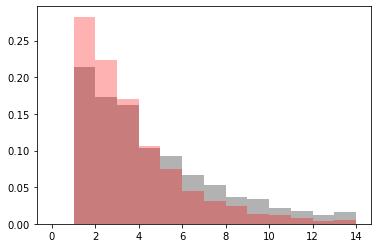

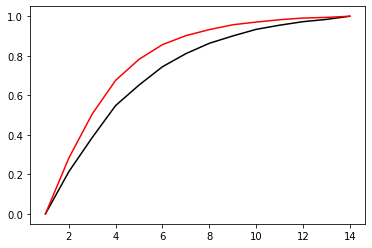

In [6]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['field_widths'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw, bins = np.arange(15), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color= 'black')

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['field_widths'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw, bins = np.arange(15), color = 'red', alpha = .3,density=True)
print(hist)


ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

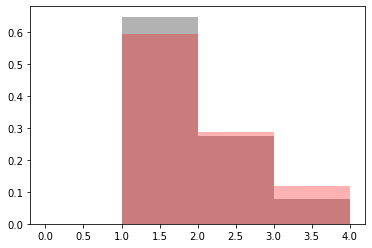

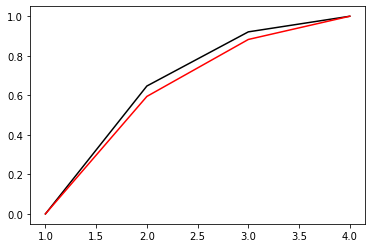

In [7]:
fig, ax = plt.subplots()
fig_cum, ax_cum = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['num_fields'])
ctrl_fw = np.concatenate(ctrl_fw)

hist, bins, _ = ax.hist(ctrl_fw[ctrl_fw>0], bins = np.arange(5), color='black', alpha = .3, density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='black')

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['num_fields'])
ko_fw = np.concatenate(ko_fw)

hist, bins, _ = ax.hist(ko_fw[ko_fw>0], bins = np.arange(5), color = 'red', alpha = .3,density=True)
ax_cum.plot(bins[1:], np.cumsum(hist), color='red')

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}


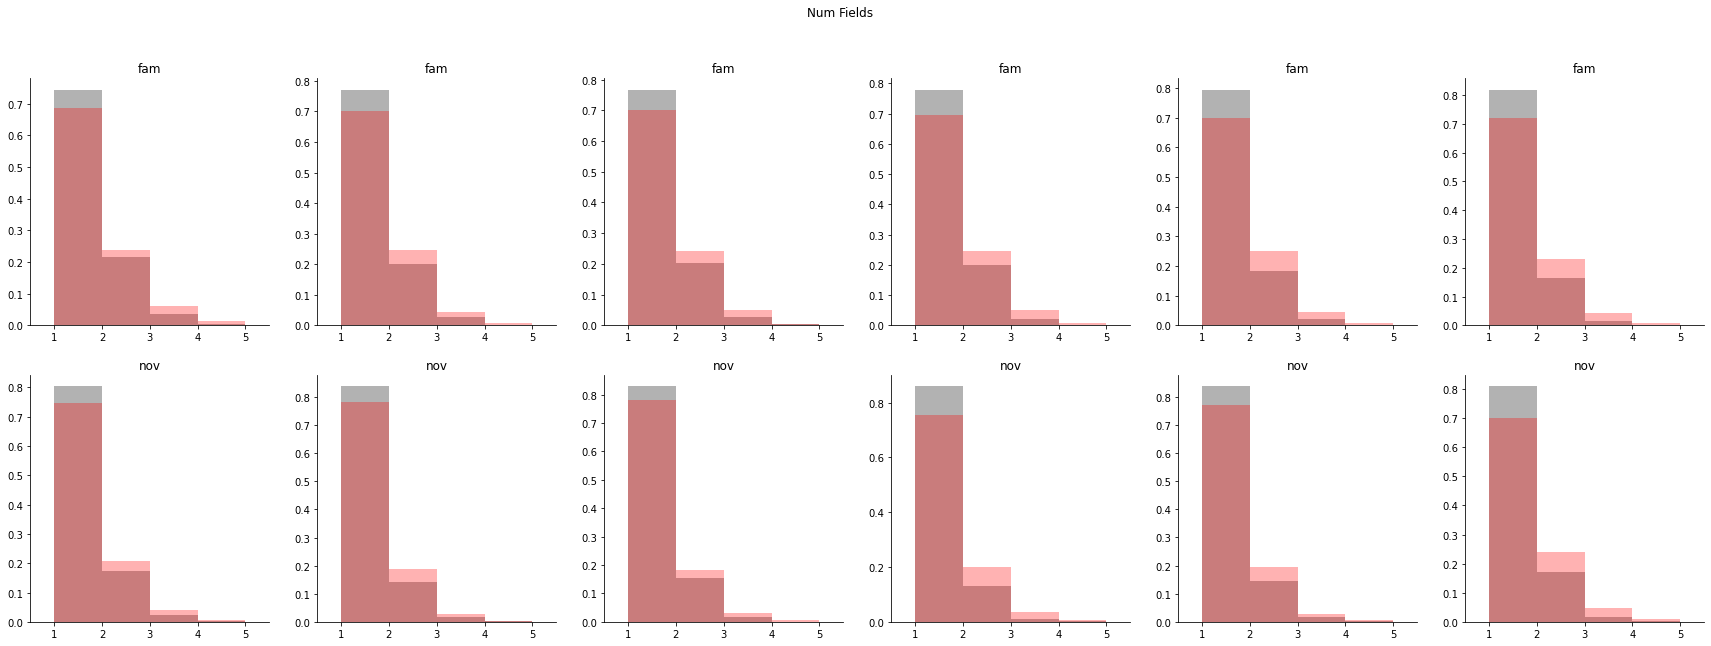

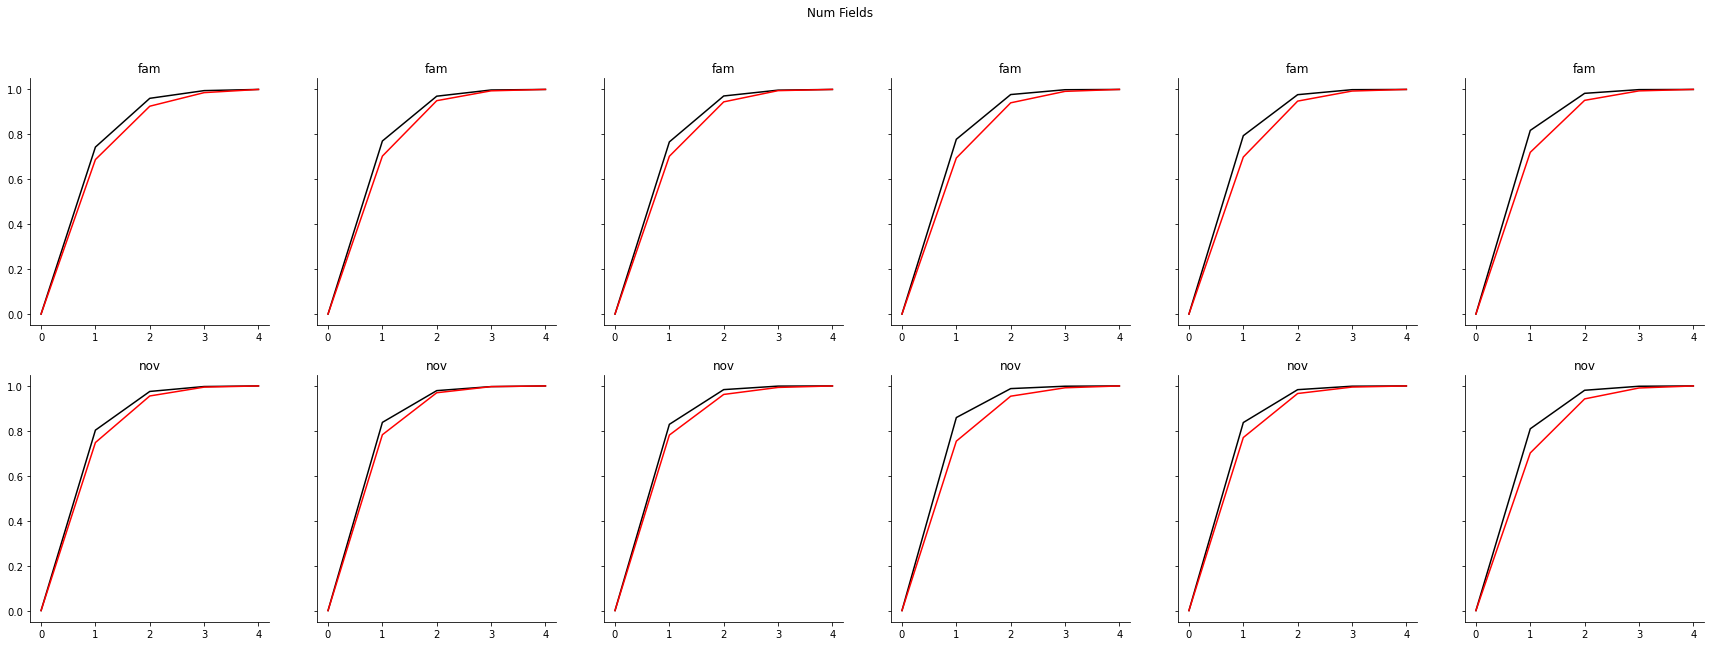

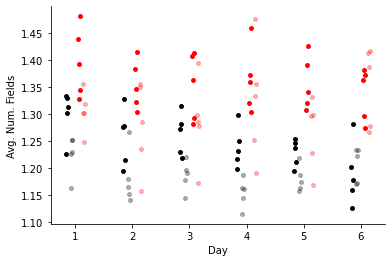

In [8]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize=[30,10],sharey=True)

fig_scat, ax_scat = plt.subplots()
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'nov': [],
                   'num_fields' : [],
                   'mouse': [], 
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})

days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ctrl_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ctrl_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
# #             dat = f[:,1]-r[:,1]
            
            
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': (day + 1)/6., #days_z[day], 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(6), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax[row,day].set_xlim([.5,5.5])
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
#             dat = ko_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ko_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising_mask, falling_mask = fm[1:, :]>fm[:-1, :], fm[:-1, :]>fm[1:, :]
            rising_mask[0,:]= False
            falling_mask[-1,:] = False
            rising, falling = rising_mask.sum(axis=0), falling_mask.sum(axis=0)
#             rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            
#             r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
#             dat = np.minimum(r, f)
            
#             dat = (fm[1:, :]>fm[:-1, :]).sum(axis=0)
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': (day+1)/6., 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(6), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Num Fields")
fig_cum.suptitle("Num Fields")

ax_scat.set_ylabel('Avg. Num. Fields')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"num_sig_fields_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"num_sig_fields_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"num_sig_fields_summary.pdf"))

In [11]:
lmm_res = MixedLM(df['num_fields'], df[['ko', 
                                        'day', 
                                        'nov', 
                                        'ko_x_nov', 
                                        'ko_x_day',
                                        'nov_x_day',
#                                         'speed',
                                        'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: num_fields
No. Observations: 120     Method:             REML      
No. Groups:       10      Scale:              0.0023    
Min. group size:  12      Log-Likelihood:     167.1275  
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.076    0.022  3.448 0.001  0.033  0.118
day           -0.114    0.033 -3.460 0.001 -0.178 -0.049
nov           -0.111    0.022 -5.049 0.000 -0.154 -0.068
ko_x_nov      -0.001    0.018 -0.055 0.956 -0.035  0.034
ko_x_day       0.064    0.041  1.576 0.115 -0.016  0.145
nov_x_day      0.090    0.031  2.924 0.003  0.030  0.151
intercept      1.313    0.018 73.225 0.000  1.278  1.348
day Var        0.002    0.024            

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 1}

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 7}
{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 5}


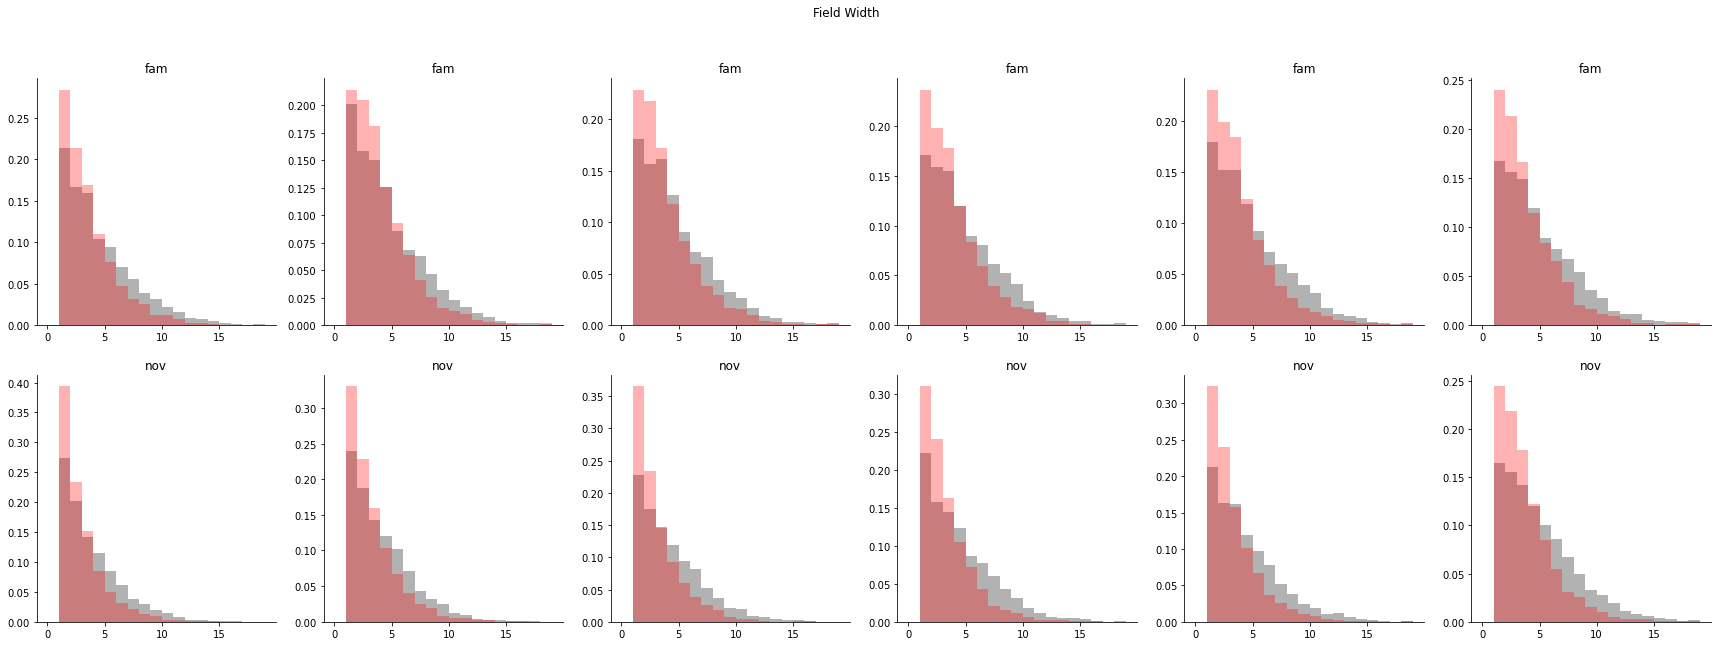

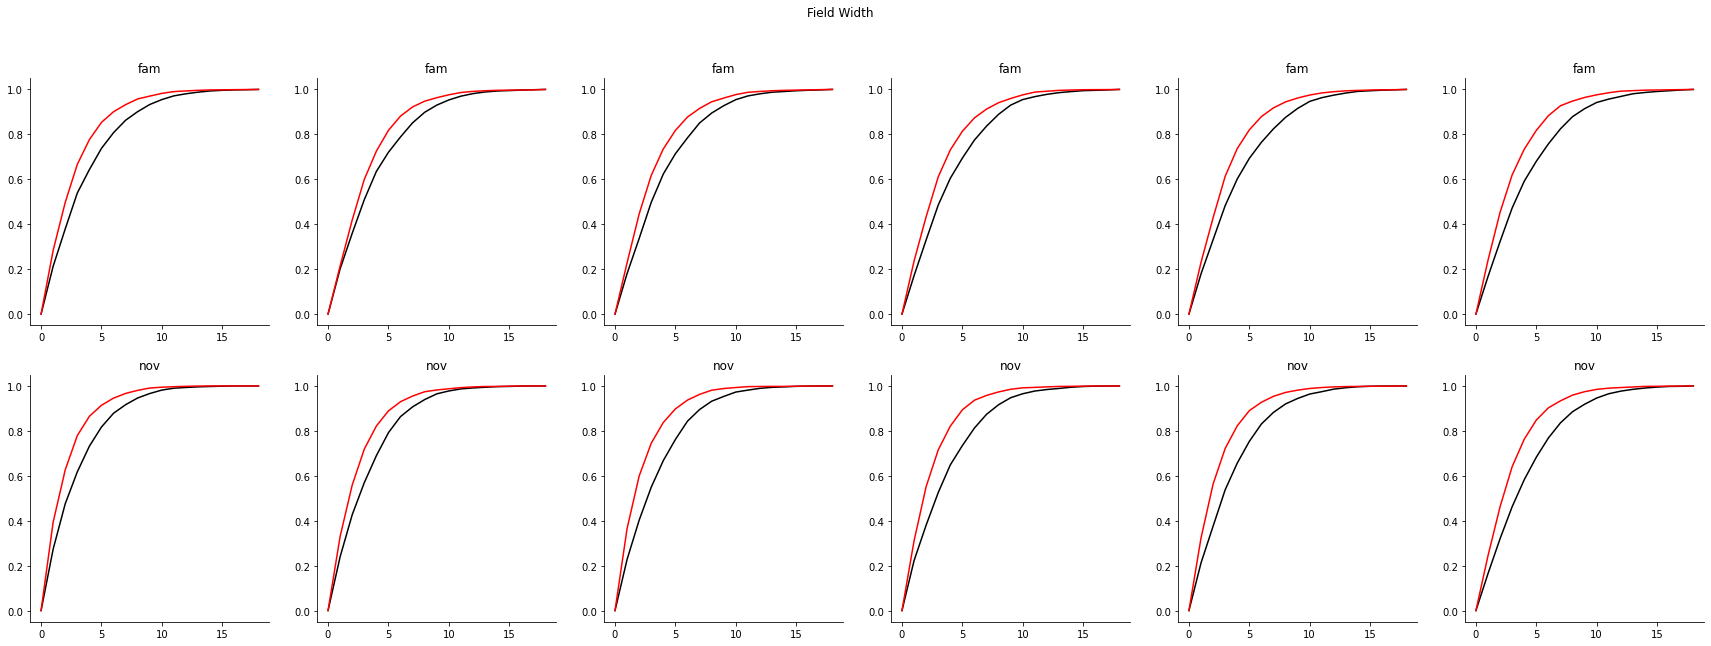

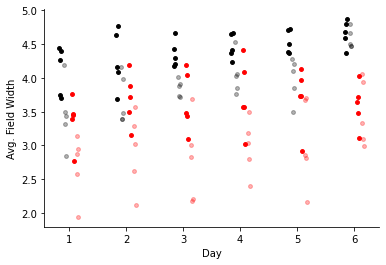

In [14]:
fig, ax = plt.subplots(2,6, figsize=[30,10])
fig_cum, ax_cum = plt.subplots(2,6, figsize= [30,10])
fig_scat, ax_scat = plt.subplots()
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'nov': [],
                   'fw' : [],
                   'mouse': [],
                   'ko_x_day': [],
                   'ko_x_nov': [],
                   'nov_x_day': [],
                   'speed': [],
                   'intercept': []})
days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             print(dat)
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': (day+1)/6.,
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': 0,
                            'ko_x_nov': 0,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        
        hist, bins, _ = ax[row,day].hist(ctrl_fw, bins = np.arange(0,20), color='black', alpha = .3, density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='black')
       
        ax[row,day].set_title(novkey)
        ax_cum[row,day].set_title(novkey)
        ax[row,day].spines['top'].set_visible(False)
        ax[row,day].spines['right'].set_visible(False)
        ax_cum[row,day].spines['top'].set_visible(False)
        ax_cum[row,day].spines['right'].set_visible(False)
        
        
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            sess = u.load_single_day(mouse,day)
            if novkey in ['fam']:
                trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
            else:
                trial_mask = sess.trial_info['LR']==sess.novel_arm
            
            r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
            r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             dat = ko_field_mask_res[mouse][day][novkey]['field_widths']
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': (day+1)/6., 
                            'nov': row, 
                            'fw': dat[dat>0].mean(), 
                            'mouse': mouse, 
                            'ko_x_day': (day+1)/6.,
                            'ko_x_nov': row,
                            'nov_x_day': row*(day+1)/6.,
                            'speed': np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:],axis=0)),
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

#         ax[row,day].hist(ko_fw, bins = np.arange(1,20), color = 'red', alpha = .3,density=True)
        hist, bins, _ = ax[row,day].hist(ko_fw, bins = np.arange(0,20), color = 'red', alpha = .3,density=True)
        ax_cum[row,day].plot(bins[:-1], np.cumsum(hist), color='red')
        
fig.suptitle("Field Width")
fig_cum.suptitle("Field Width")

ax_scat.set_ylabel('Avg. Field Width')
ax_scat.set_xlabel('Day')
ax_scat.set_xticks([6*day for day in range(6)])
ax_scat.set_xticklabels(np.arange(1,7))
ax_scat.spines['top'].set_visible(False)
ax_scat.spines['right'].set_visible(False)

fig.savefig(os.path.join(figdir,"field_width_hist.pdf"))
fig_cum.savefig(os.path.join(figdir,"field_width_cumhist.pdf"))
fig_scat.savefig(os.path.join(figdir,"field_width_summary.pdf"))
        

In [17]:
lmm_res = MixedLM(df['fw'],  df[['ko', 
                                 'day', 
                                 'nov', 
                                 'ko_x_nov', 
                                 'ko_x_day',
                                 'nov_x_day',
#                                  'speed',
                                 'intercept']], df['mouse'], exog_re = df['day'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())
print(lmm_resf.bse_fe)
print(lmm_resf.pvalues)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: fw      
No. Observations: 120     Method:             REML    
No. Groups:       10      Scale:              0.0752  
Min. group size:  12      Log-Likelihood:     -33.8057
Max. group size:  12      Converged:          Yes     
Mean group size:  12.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
ko          -0.542    0.125 -4.347 0.000 -0.786 -0.298
day          0.625    0.255  2.454 0.014  0.126  1.125
nov         -0.780    0.125 -6.254 0.000 -1.024 -0.535
ko_x_nov    -0.171    0.100 -1.711 0.087 -0.368  0.025
ko_x_day    -0.403    0.338 -1.192 0.233 -1.066  0.260
nov_x_day    0.538    0.176  3.059 0.002  0.193  0.883
intercept    4.033    0.102 39.542 0.000  3.833  4.233
day Var      0.209    0.423                           

ko           0.124

In [12]:
sess = u.load_single_day(ko_mice[4],0)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


(array([181., 312., 317., 360., 259., 116.,  61.,  27.,  10.,   6.]),
 array([0.00171873, 0.02958184, 0.05744495, 0.08530805, 0.11317116,
        0.14103427, 0.16889737, 0.19676048, 0.22462359, 0.2524867 ,
        0.2803498 ]),
 <BarContainer object of 10 artists>)

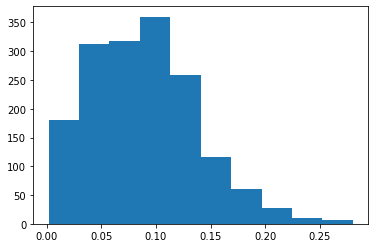

In [13]:
fig,ax = plt.subplots()
ax.hist(sess.trial_matrices['speed'].ravel())

### Field edge analysis

In [8]:
def field_shifts(mouse, day, fm_res, novkey, pcnt_th = .25, act_th = .25, plot = False):
    sess = u.load_single_day(mouse,day)
    
    ledge, redge = fm_res[mouse][day][novkey]['rising_edges'], fm_res[mouse][day][novkey]['falling_edges']

    border_cells = (ledge[:,1]==0) #+ (redge[:,1]>=28) > 0
    ledge, redge = ledge[~border_cells,:], redge[~border_cells,:]
    ledge[:,1], redge[:,1] = np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29)

    if novkey in ['fam']:
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
    else:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
        
        
    shift = []
    form_lap_vel = []
    field_width = []
    form_lap = []
    field_var = []
    for field in range(ledge.shape[0]):
        fieldmat = sess.trial_matrices['spks'][trial_mask,:,:][:,np.maximum(ledge[field,1],0):redge[field,1],ledge[field,0]]
        speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)
        fieldmat[np.isnan(fieldmat)]=1E-5
        activity_th = act_th*np.amax(fieldmat.ravel())
        fieldmat_th = np.amax(1*(fieldmat>activity_th), axis=1)
        formation_laps = fieldmat_th * (sp.ndimage.convolve1d(fieldmat_th, np.ones([5,]), mode='constant', cval = 0)>=1)
        formation_lap = np.nonzero(formation_laps)[0][0]
        

        if fieldmat_th[formation_lap:].mean()>pcnt_th and redge[field,1]-ledge[field,1]>=3 and formation_laps.sum()>0:
            
            
#             form_lap_vel.append(np.nanmean(speed[np.maximum(formation_lap-1,0):formation_lap+2]))
            form_lap_vel.append(speed[formation_lap])
            form_lap.append(formation_lap)
            field_width.append(redge[field,1]-ledge[field,1])
            
            form_argmax = sp.ndimage.center_of_mass(fieldmat[formation_lap,:])[0] 
#             form_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[np.maximum(formation_lap-1,0):formation_lap+2,:],axis=0))[0] 
#             print(form_argmax, sp.ndimage.center_of_mass(fieldmat[formation_lap,:]))
            field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]
#             field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+2:,:], axis=0))[0] 
    
            shift.append(field_argmax-form_argmax)
        
            avg_act = np.nanmean(fieldmat[formation_lap:, :], axis=1)
            avg_act_norm = avg_act/np.nanmax(avg_act)
            field_var.append(np.nanvar(avg_act_norm))
            
            if plot:
                fig, ax = plt.subplots(1,2, figsize= [10,5])
                ax[0].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')
                ax[0].vlines([ledge[field,1], redge[field,1]], 0, trial_mask.sum(), color= 'blue')
                ax[0].hlines(formation_lap, 0,30)
                ax[0].scatter(form_argmax+ ledge[field,1],formation_lap,color='green')
                ax[0].vlines(field_argmax + ledge[field,1], 0 , trial_mask.sum(), color='red')
                ax[0].set_title("%d" % field)
                
                ax[1].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')
                
                mousedir = os.path.join(figdir, sess.mouse) 
                os.makedirs(mousedir, exist_ok = True)
                fig.savefig(os.path.join(mousedir, "field_%d.pdf" % field))
                
    return {'shift': np.array(shift), 'formation_lap': np.array(form_lap), 'width': np.array(field_width), 'init_speed': np.array(form_lap_vel), 'field_var': np.array(field_var)}

In [15]:

_ = field_shifts(ctrl_mice[0], 0, ctrl_field_mask_res, 'nov', plot=False)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


In [16]:
_ = field_shifts(ko_mice[2], 0, ko_field_mask_res, 'nov', plot=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [9]:
ctrl_nov_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'nov') for day in range(6)] for mouse in ctrl_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}


<ipython-input-8-25e5f9316e9a>:42: RuntimeWarning: Mean of empty slice
  field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene

<ipython-input-8-25e5f9316e9a>:23: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [10]:
ko_nov_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'nov') for day in range(6)] for mouse in ko_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
<ipython-input-8-25e5f9316e9a>:42: RuntimeWarning: Mean of empty slice
  field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'ses

In [11]:
ctrl_fam_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'fam') for day in range(6)] for mouse in ctrl_mice}
ko_fam_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'fam') for day in range(6)] for mouse in ko_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


<ipython-input-8-25e5f9316e9a>:42: RuntimeWarning: Mean of empty slice
  field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]


({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3

0
N control = 2796, N KO = 2525, t=-6.387361, p = 1.831254e-10
0
N control = 2811, N KO = 2841, t=-6.345413, p = 2.390851e-10
0
N control = 2911, N KO = 3080, t=-1.751075, p = 7.998416e-02
0
N control = 2807, N KO = 3195, t=-0.525210, p = 5.994568e-01
0
N control = 3095, N KO = 2580, t=-4.532743, p = 5.941868e-06
0
N control = 3730, N KO = 3690, t=-4.320479, p = 1.577210e-05


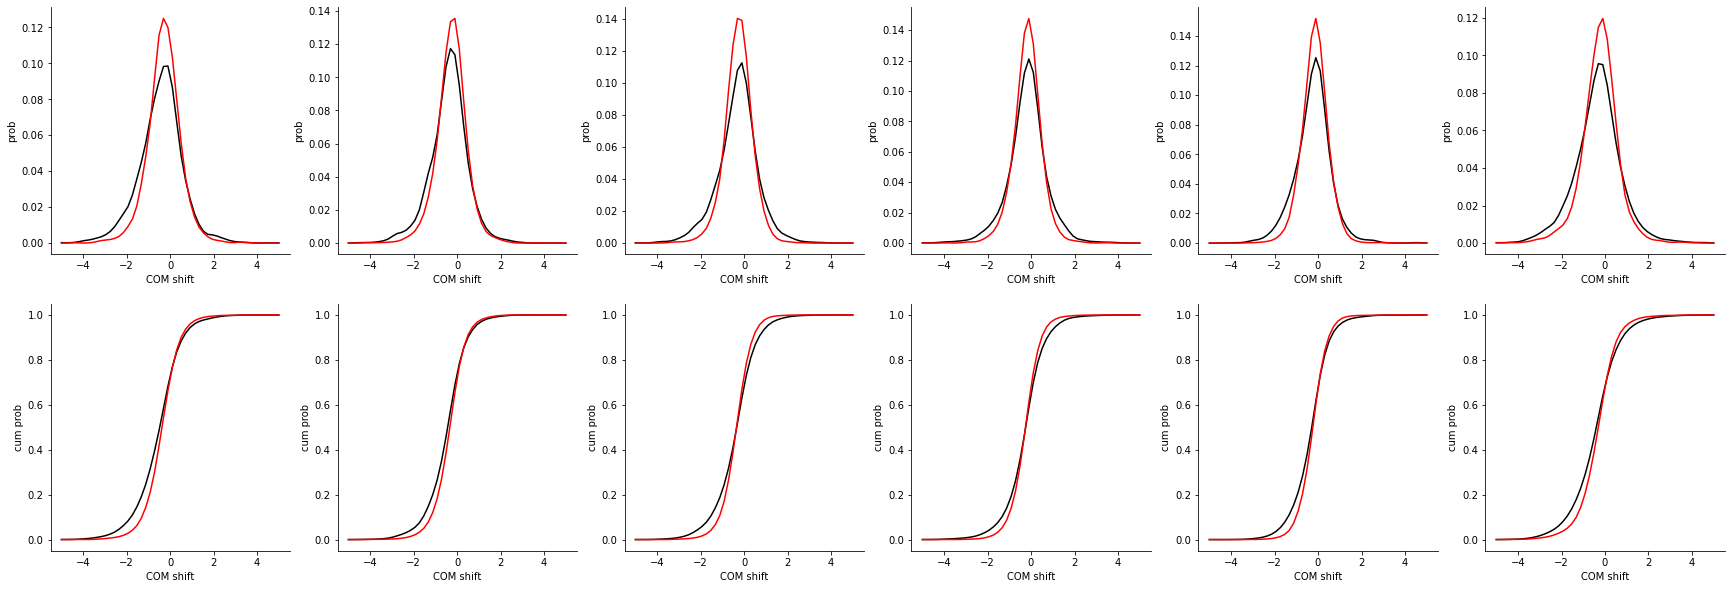

In [24]:
df_shifts = pd.DataFrame({'mouse': [],
                          'm': [],
                          'day': [],
                         'dz': [],
                         'ko': [],
                         'nov': [],
                         'nov_x_dz': [],
                         'ko_x_dz': [],
                         'ko_x_nov': [],
                         'ko_x_nov_x_dz':[],
                         'shifts': [],
                         'width': [],
                         'formation_lap': [],
                         'init_speed': [],
                         'init_speed_x_ko': [],
                         'field_var': [],
                         'ko_x_speed': [], 
                         'intercept': []})

fig,ax = plt.subplots(2,6, figsize= [30,10])
days_z = sp.stats.zscore(np.arange(6))
for day, dz in enumerate(days_z):
    ctrl_shifts = []
    ctrl_mu = []
    
    for m, mouse in enumerate(ctrl_mice):
        ctrl_shifts.append(ctrl_nov_shifts[mouse][day]['shift'])
        ctrl_mu.append(ctrl_nov_shifts[mouse][day]['shift'].mean())
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ctrl_nov_shifts[mouse][day]['shift'], 
                                                        ctrl_nov_shifts[mouse][day]['width'], 
                                                        ctrl_nov_shifts[mouse][day]['init_speed'],
                                                        ctrl_nov_shifts[mouse][day]['formation_lap'],
                                                        ctrl_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 1,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': 0,
                                              'field_var': fvar,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ctrl_fam_shifts[mouse][day]['shift'], 
                                                        ctrl_fam_shifts[mouse][day]['width'], 
                                                        ctrl_fam_shifts[mouse][day]['init_speed'],
                                                        ctrl_fam_shifts[mouse][day]['formation_lap'],
                                                        ctrl_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 0,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': 0,
                                              'field_var': fvar,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)
    ctrl_shifts = np.concatenate(ctrl_shifts)
    ctrl_shifts = ctrl_shifts[~np.isnan(ctrl_shifts)]
    print(np.isnan(ctrl_shifts).sum())
    
        
    ko_shifts = []
    ko_mu = []
    for m, mouse in enumerate(ko_mice):
        ko_shifts.append(ko_nov_shifts[mouse][day]['shift'])
        ko_mu.append(ko_nov_shifts[mouse][day]['shift'].mean())
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ko_nov_shifts[mouse][day]['shift'], 
                                                        ko_nov_shifts[mouse][day]['width'], 
                                                        ko_nov_shifts[mouse][day]['init_speed'],
                                                        ko_nov_shifts[mouse][day]['formation_lap'],
                                                        ko_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 1,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': dz,
                                              'ko_x_nov': 1,
                                              'ko_x_nov_x_dz': 1,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': speed,
                                              'field_var': fvar,
                                              'ko_x_speed': speed,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ko_fam_shifts[mouse][day]['shift'], 
                                                        ko_fam_shifts[mouse][day]['width'], 
                                                        ko_fam_shifts[mouse][day]['init_speed'],
                                                        ko_fam_shifts[mouse][day]['formation_lap'],
                                                        ko_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 0,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': 0,
                                              'ko_x_nov': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': speed,
                                              'field_var': fvar,
                                              'ko_x_speed': speed, 
                                              'intercept': 1}, ignore_index=True)
    ko_shifts = np.concatenate(ko_shifts)
    ko_shifts = ko_shifts[~np.isnan(ko_shifts)]

    _x = np.linspace(-5,5)
    _ctrl_hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],.3, _x[:,np.newaxis]).mean(axis=1)
    _ctrl_hist /= _ctrl_hist.sum()
    ax[0,day].plot(_x,_ctrl_hist, color='black')
    ax[1,day].plot(_x,np.cumsum(_ctrl_hist), color='black')
    _ko_hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],.3, _x[:,np.newaxis]).mean(axis=1)
    _ko_hist /= _ko_hist.sum()
    ax[0,day].plot(_x,_ko_hist, color='red')
    ax[1,day].plot(_x,np.cumsum(_ko_hist), color='red')

#     ax[0,day].vlines(ctrl_shifts.mean(),0,.09, color='black')

#     ax[0,day].vlines(ko_shifts.mean(),0,.09, color='red')

    
    ax[0,day].set_xlabel("COM shift")
    ax[0,day].set_ylabel('prob')
    ax[0,day].spines['top'].set_visible(False)
    ax[0,day].spines['right'].set_visible(False)

    
    ax[1,day].set_xlabel("COM shift")
    ax[1,day].set_ylabel('cum prob')
    ax[1,day].spines['top'].set_visible(False)
    ax[1,day].spines['right'].set_visible(False)

    t,p = sp.stats.ttest_ind(ctrl_shifts,ko_shifts)
    print("N control = %d, N KO = %d, t=%f, p = %e" % (ctrl_shifts.shape[0], ko_shifts.shape[0],t,p))

fig.savefig(os.path.join(figdir, "com_shift_by_day.pdf"), format = 'pdf')

(array([ 6130., 18047., 18658., 13785.,  9020.,  6211.,  3712.,  1417.,
          515.,    93.]),
 array([0.01526326, 0.0761412 , 0.13701914, 0.19789709, 0.25877503,
        0.31965297, 0.38053091, 0.44140885, 0.50228679, 0.56316474,
        0.62404268]),
 <BarContainer object of 10 artists>)

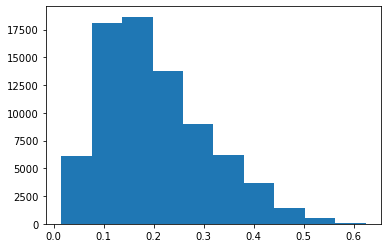

In [13]:
fig, ax = plt.subplots()
ax.hist(df_shifts['init_speed'])

In [14]:
aov = mixed_anova(data=df_shifts, dv='shifts', between='ko', within='day', subject='m')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.101444    1    8  0.101444  3.879664  0.084385  0.326580   
1          day  0.277335    5   40  0.055467  5.904526  0.000354  0.424648   
2  Interaction  0.009894    5   40  0.001979  0.210635  0.956041  0.025654   

      eps  
0     NaN  
1  0.6216  
2     NaN  


In [22]:
print(df_shifts[df_shifts['ko']==0].shape)
print(df_shifts[df_shifts['ko']==1].shape)

(38170, 18)
(39418, 18)


In [15]:

lmm_res = MixedLM(df_shifts['shifts'], df_shifts[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'ko_x_nov', 'init_speed',  'init_speed_x_ko', 'intercept']], 
                  df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: shifts      
No. Observations:  77588   Method:             REML        
No. Groups:        10      Scale:              0.8637      
Min. group size:   2945    Log-Likelihood:     -104451.7838
Max. group size:   13705   Converged:          Yes         
Mean group size:   7758.8                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
ko               0.013    0.050   0.258 0.796 -0.086  0.112
dz               0.095    0.006  16.474 0.000  0.084  0.107
nov             -0.007    0.010  -0.688 0.492 -0.025  0.012
nov_x_dz        -0.042    0.007  -6.192 0.000 -0.055 -0.028
ko_x_dz         -0.023    0.007  -3.340 0.001 -0.036 -0.009
ko_x_nov         0.008    0.013   0.570 0.569 -0.019  0.034
init_speed      -0.775    0.045 -17.205 0.000 -0.86

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [16]:
print(lmm_resf.pvalues)

ko                 7.961442e-01
dz                 5.665670e-61
nov                4.915963e-01
nov_x_dz           5.929351e-10
ko_x_dz            8.366353e-04
ko_x_nov           5.687391e-01
init_speed         2.456587e-66
init_speed_x_ko    9.606420e-03
intercept          4.264161e-04
Group Var          5.117809e-02
dtype: float64


In [17]:

df_nov = df_shifts#[df_shifts['nov']==1]
lmm_res = MixedLM(df_nov['shifts'], df_nov[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'init_speed',  'intercept']], df_nov['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shifts      
No. Observations: 77588   Method:             REML        
No. Groups:       10      Scale:              0.8637      
Min. group size:  2945    Log-Likelihood:     -104450.2231
Max. group size:  13705   Converged:          Yes         
Mean group size:  7758.8                                  
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              0.056    0.049   1.143 0.253 -0.040  0.151
dz              0.094    0.006  16.321 0.000  0.083  0.106
nov            -0.004    0.007  -0.525 0.600 -0.017  0.010
nov_x_dz       -0.041    0.007  -6.149 0.000 -0.054 -0.028
ko_x_dz        -0.020    0.007  -2.968 0.003 -0.033 -0.007
init_speed     -0.705    0.036 -19.747 0.000 -0.775 -0.635
intercept      -0.143    0.035  -4.040 0.000 -0.213 -0.074
Group Va

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [18]:
df_nov = df_shifts[df_shifts['nov']==0]
lmm_res = MixedLM(df_nov['shifts'], df_nov[['ko', 'dz', 'ko_x_dz', 'init_speed',  'intercept']], df_nov['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shifts     
No. Observations: 41527   Method:             REML       
No. Groups:       10      Scale:              1.0136     
Min. group size:  1674    Log-Likelihood:     -59235.9590
Max. group size:  7762    Converged:          Yes        
Mean group size:  4152.7                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             0.036    0.067   0.542 0.588 -0.095  0.168
dz             0.102    0.007  14.202 0.000  0.088  0.117
ko_x_dz       -0.026    0.010  -2.620 0.009 -0.046 -0.007
init_speed    -1.035    0.053 -19.653 0.000 -1.138 -0.932
intercept     -0.071    0.049  -1.443 0.149 -0.166  0.025
Group Var      0.011    0.006                            



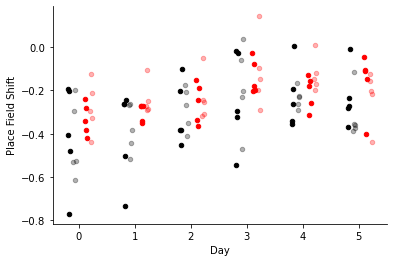

In [19]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 5, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Shift')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir, "field_shift_summary.pdf"))

In [40]:
df_fv = df_shifts[df_shifts['day']<4]
lmm_res = MixedLM(df_fv['field_var'], df_fv[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'ko_x_nov',  'intercept']], 
                  df_fv['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var  
No. Observations: 50207   Method:             REML       
No. Groups:       10      Scale:              0.0004     
Min. group size:  2020    Log-Likelihood:     123079.5229
Max. group size:  8782    Converged:          Yes        
Mean group size:  5020.7                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             0.000    0.003   0.082 0.935 -0.005  0.006
dz            -0.004    0.000 -14.237 0.000 -0.004 -0.003
nov            0.023    0.000  73.869 0.000  0.023  0.024
nov_x_dz      -0.002    0.000  -7.035 0.000 -0.003 -0.001
ko_x_dz        0.001    0.000   3.451 0.001  0.000  0.002
ko_x_nov       0.002    0.000   5.948 0.000  0.001  0.003
intercept      0.044    0.002  21.870 0.000  0.040  0.047
Group Var      0.000    

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [44]:
aov = mixed_anova(data = df_fv[df_fv['nov'] == 0], dv = 'field_var', between = 'ko', within= 'day', subject = 'm')
print(aov)

        Source            SS  DF1  DF2            MS          F     p-unc  \
0           ko  6.789458e-08    1    8  6.789458e-08   0.001193  0.973296   
1          day  1.769821e-04    3   24  5.899403e-05  11.064654  0.000094   
2  Interaction  1.821263e-05    3   24  6.070877e-06   1.138626  0.353487   

        np2       eps  
0  0.000149       NaN  
1  0.580375  0.800469  
2  0.124595       NaN  


/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/pingouin/distribution.py:950: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d)**d


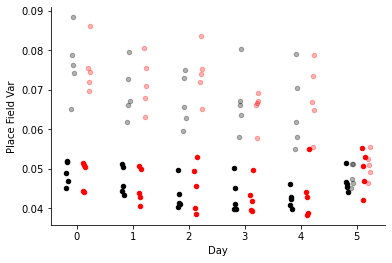

In [33]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 5, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Var')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir, "field_var_summary.pdf"))

In [38]:
lmm_res = MixedLM(df_shifts['width'], df_shifts[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'ko_x_nov', 'init_speed',  'init_speed_x_ko', 'intercept']], 
                  df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: width       
No. Observations:  77588   Method:             REML        
No. Groups:        10      Scale:              7.9953      
Min. group size:   2945    Log-Likelihood:     -190773.7984
Max. group size:   13705   Converged:          Yes         
Mean group size:   7758.8                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
ko              -0.707    0.150  -4.716 0.000 -1.001 -0.413
dz              -0.079    0.018  -4.508 0.000 -0.114 -0.045
nov             -0.809    0.029 -27.836 0.000 -0.866 -0.752
nov_x_dz         0.329    0.020  16.102 0.000  0.289  0.369
ko_x_dz         -0.100    0.021  -4.821 0.000 -0.140 -0.059
ko_x_nov         0.056    0.041   1.381 0.167 -0.024  0.136
init_speed       7.849    0.137  57.262 0.000  7.58

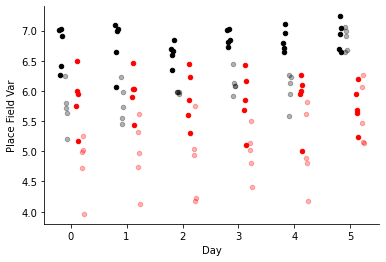

In [39]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 5, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['width'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+2)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Width')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir, "field_width_summary.pdf"))

In [28]:
t,p = sp.stats.ttest_ind(plot_arr[0,0,:,0],plot_arr[1,0,:,0])
print(t,p)

-0.7041790275329918 0.5013014655161836


-0.09389328308608423 0.9251971930505488
4.889753581562016 1.0330599173335153e-06
-9.299029167721006 1.8299665836586803e-20
-4.00275191315821 6.322838547952424e-05
-10.16244429845107 4.3378150071341944e-24
-12.644876503435315 2.795077433456213e-36


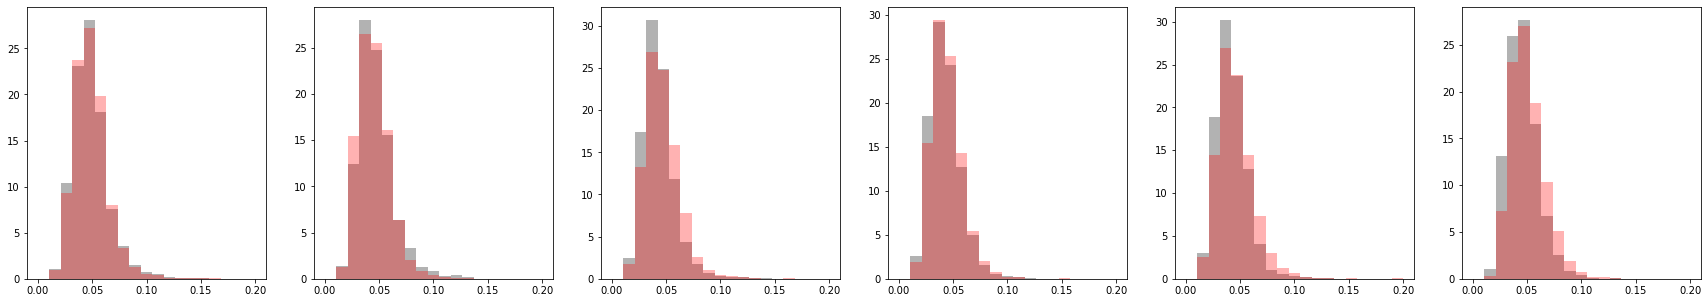

In [28]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.linspace(0,.2, num=20)
for day in range(6):
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                             df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)])
    print(t,p)

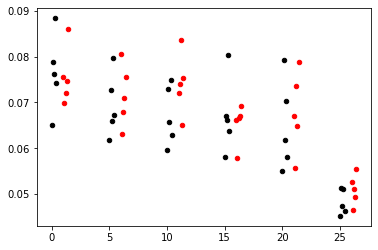

In [34]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        ax.scatter(5*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        ax.scatter(5*day+.1*m + 1, np.nanmean(shifts), color='red', s=20)
    

In [31]:
lmm_res = MixedLM(df_shifts['field_var'], df_shifts[['ko', 'dz', 'ko_x_dz','nov', 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var  
No. Observations: 77588   Method:             REML       
No. Groups:       10      Scale:              0.0004     
Min. group size:  2945    Log-Likelihood:     191685.6678
Max. group size:  13705   Converged:          Yes        
Mean group size:  7758.8                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             0.001    0.003   0.408 0.684 -0.004  0.007
dz            -0.004    0.000 -43.101 0.000 -0.005 -0.004
ko_x_dz        0.001    0.000   8.269 0.000  0.001  0.002
nov            0.021    0.000 139.554 0.000  0.020  0.021
intercept      0.045    0.002  22.828 0.000  0.041  0.049
Group Var      0.000    0.000                            



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


(5799, 18) -0.10236758202545217 5.528465131978188e-15
(5288, 18) -0.011425044499839578 0.40617457511549915


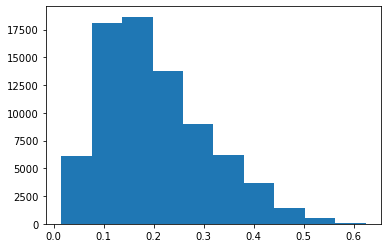

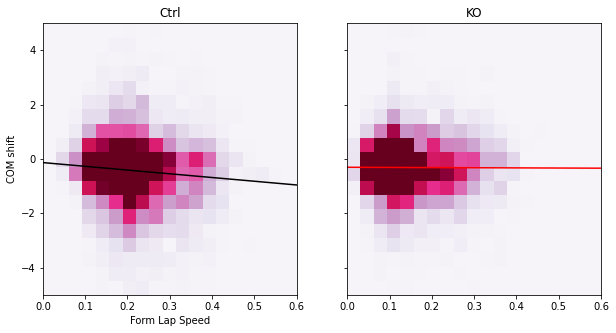

In [23]:
fig, ax = plt.subplots()
ax.hist(df_shifts['init_speed'])

fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) ]
ax[0].hist2d(ctrl_df['init_speed'], ctrl_df['shifts'], bins=(np.linspace(0,.6,num=20),np.linspace(-5,5,num=20)),density=True, vmax = 1, cmap = 'PuRd') #, color='black')

res = sp.stats.linregress(ctrl_df['init_speed'],ctrl_df['shifts'])
x = np.linspace(0,.6)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(ctrl_df['init_speed'],ctrl_df['shifts'])
r,p = sp.stats.spearmanr(ctrl_df['init_speed'],ctrl_df['shifts'])
print(ctrl_df.shape,r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0)]
ax[1].hist2d(ko_df['init_speed'],ko_df['shifts'], bins=(np.linspace(0,.6,num=20),np.linspace(-5,5,num=20)), density=True, vmax=1, cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(ko_df['init_speed'],ko_df['shifts'])
r,p = sp.stats.spearmanr(ko_df['init_speed'],ko_df['shifts'])

res = sp.stats.linregress(ko_df['init_speed'], ko_df['shifts'])
x = np.linspace(0,.6)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(ko_df.shape,r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('COM shift')
fig.savefig(os.path.join(figdir,"initspeed_vs_shifts.pdf"))

0
[0.         0.03157895 0.06315789 0.09473684 0.12631579 0.15789474
 0.18947368 0.22105263 0.25263158 0.28421053 0.31578947 0.34736842
 0.37894737 0.41052632 0.44210526 0.47368421 0.50526316 0.53684211
 0.56842105 0.6       ] [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
0.17070607256206777 3.616673207250699e-39
0.2271557281395265 7.439143070744868e-63


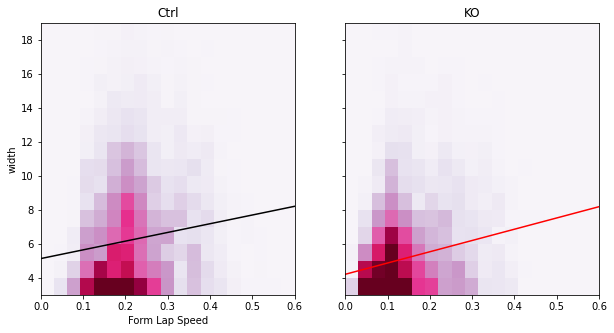

In [37]:

fig, ax = plt.subplots(1,2,figsize=[10,5], sharey=True, sharex=True)
ctrl_df = df_shifts[(df_shifts['ko']==0) & (df_shifts['day']==0) ]
h, xedges, yedges, _ = ax[0].hist2d(ctrl_df['init_speed'], ctrl_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)),density=True, vmax = 1, cmap = 'PuRd') #, color='black')
print(np.isnan(h).sum())
print(xedges, yedges)

res = sp.stats.linregress(ctrl_df['init_speed'],ctrl_df['width'])
x = np.linspace(0,.6)
ax[0].plot(x,res.slope*x + res.intercept, color='black')

r,p = sp.stats.pearsonr(ctrl_df['init_speed'],ctrl_df['width'])
r,p = sp.stats.spearmanr(ctrl_df['init_speed'],ctrl_df['width'])
print(r,p)

# fig, ax = plt.subplots()
ko_df = df_shifts[(df_shifts['ko']==1) & (df_shifts['day']==0)]
ax[1].hist2d(ko_df['init_speed'],ko_df['width'], bins=(np.linspace(0,.6,num=20),np.arange(3,20)), density=True, vmax=1, cmap = 'PuRd') #, color='red')
r,p = sp.stats.pearsonr(ko_df['init_speed'],ko_df['width'])
r,p = sp.stats.spearmanr(ko_df['init_speed'],ko_df['width'])

res = sp.stats.linregress(ko_df['init_speed'], ko_df['width'])
x = np.linspace(0,.6)
ax[1].plot(x,res.slope*x + res.intercept, color='red')
print(r,p)

ax[0].set_title('Ctrl')
ax[1].set_title('KO')
ax[0].set_xlabel('Form Lap Speed')
ax[0].set_ylabel('width')
fig.savefig(os.path.join(figdir,"initspeed_vs_width.pdf"))

In [66]:
speed_z = sp.stats.zscore(df_shifts['init_speed']._values)
df_shifts['init_speed'] = speed_z
df_shifts['ko_x_speed'] = speed_z*df_shifts['ko']._values
lmm_res = MixedLM(df_shifts['width'], df_shifts[['ko', 'dz', 'ko_x_dz','init_speed', 'init_speed_x_ko', 'intercept']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: width       
No. Observations: 77588   Method:             REML        
No. Groups:       10      Scale:              8.1634      
Min. group size:  2945    Log-Likelihood:     -191578.6760
Max. group size:  13705   Converged:          Yes         
Mean group size:  7758.8                                  
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
ko          -0.580     0.142  -4.073  0.000  -0.859  -0.301
dz           0.078     0.015   5.345  0.000   0.050   0.107
ko_x_dz     -0.107     0.021  -5.131  0.000  -0.148  -0.066
init_speed   0.795     0.015  54.755  0.000   0.767   0.824
ko_x_speed   0.095     0.024   3.999  0.000   0.049   0.142
intercept    6.217     0.101  61.845  0.000   6.020   6.414
Group Var    0.049     0.009                              

5.773612624611505 9.079796606599732e-09
4.888152400451535 1.095548468597884e-06
5.270232628479259 1.4956091386874433e-07
5.9048277000737786 4.049025830261659e-09
3.509481656130859 0.00045783820864629904
1.3679174231110098 0.17142311390123907


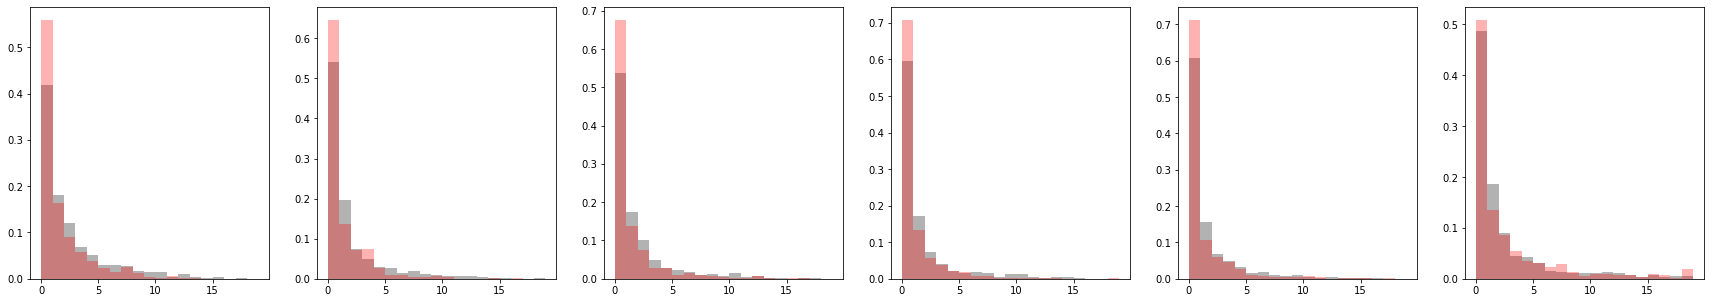

In [74]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.arange(20)
for day in range(6):
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) ],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day)],
                             df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)])
    print(t,p)

In [75]:
lmm_res = MixedLM(df_shifts['formation_lap'], df_shifts[['ko', 'dz', 'ko_x_dz']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: formation_lap
No. Observations: 14313   Method:             REML         
No. Groups:       10      Scale:              24.8484      
Min. group size:  484     Log-Likelihood:     -43328.0547  
Max. group size:  2073    Converged:          Yes          
Mean group size:  1431.3                                   
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
ko            1.501     0.727   2.064  0.039   0.076   2.926
dz            0.693     0.051  13.459  0.000   0.592   0.794
ko_x_dz       0.225     0.085   2.648  0.008   0.059   0.392
Group Var     2.615     0.249                               

